In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [ ]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [ ]:
citations.sample(frac=1).head()


,target,source
4168,134199,447224
5205,643221,1131334
4301,153063,561595
5275,647447,577331
4310,154047,1133846


In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)


Papers shape: (2708, 1435)


In [ ]:
print(papers.sample(5).T)



                         2252     1199        2520                   108   \
paper_id               459216  1153275        4878                  50337   
term_0                      0        0           0                      0   
term_1                      0        0           0                      0   
term_2                      0        0           0                      0   
term_3                      0        0           0                      0   
...                       ...      ...         ...                    ...   
term_1429                   0        0           0                      0   
term_1430                   0        0           0                      0   
term_1431                   0        0           0                      0   
term_1432                   0        0           0                      0   
subject    Genetic_Algorithms   Theory  Case_Based  Probabilistic_Methods   

                      1149  
paper_id            193931  
term_0           

In [ ]:
print(papers.subject.value_counts())


Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [ ]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])



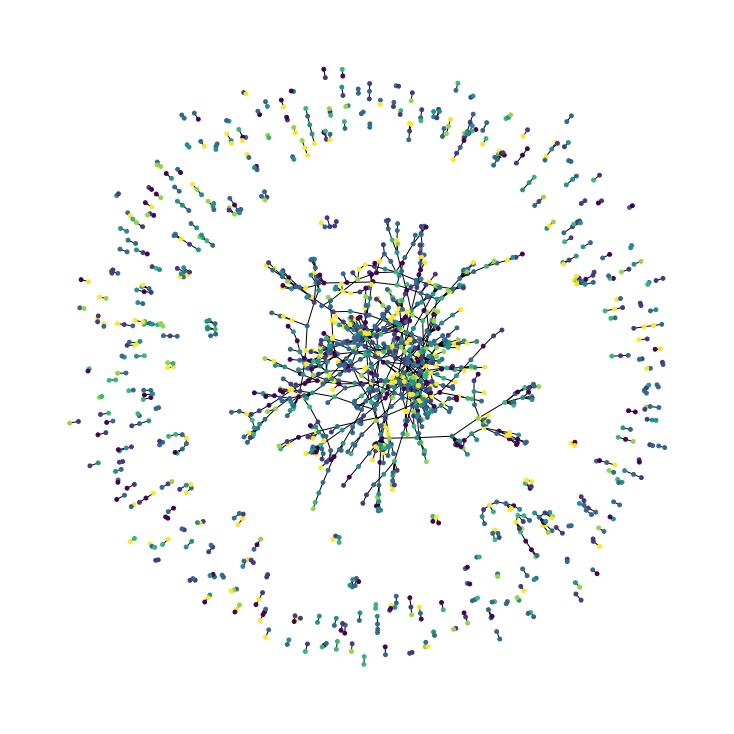

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)



In [ ]:
train_data, test_data = [], []
for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.7
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)



Train data shape: (1899, 1435)
Test data shape: (809, 1435)


In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [ ]:
history_1 = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
7/7 [==============================] - 5s 104ms/step - loss: 3.7217 - acc: 0.2045 - val_loss: 1.9642 - val_acc: 0.1719
Epoch 2/300
7/7 [==============================] - 0s 26ms/step - loss: 3.3622 - acc: 0.1958 - val_loss: 1.9712 - val_acc: 0.1895
Epoch 3/300
7/7 [==============================] - 0s 23ms/step - loss: 3.1634 - acc: 0.1964 - val_loss: 1.9632 - val_acc: 0.1860
Epoch 4/300
7/7 [==============================] - 0s 25ms/step - loss: 2.9990 - acc: 0.2032 - val_loss: 1.9503 - val_acc: 0.1544
Epoch 5/300
7/7 [==============================] - 0s 25ms/step - loss: 2.8546 - acc: 0.2094 - val_loss: 1.9373 - val_acc: 0.1439
Epoch 6/300
7/7 [==============================] - 0s 25ms/step - loss: 2.8068 - acc: 0.2057 - val_loss: 1.9269 - val_acc: 0.1404
Epoch 7/300
7/7 [==============================] - 0s 26ms/step - loss: 2.6570 - acc: 0.2082 - val_loss: 1.9178 - val_acc: 0.1474
Epoch 8/300
7/7 [==============================] - 0s 25ms/step - loss: 2.6420 - acc: 0.2

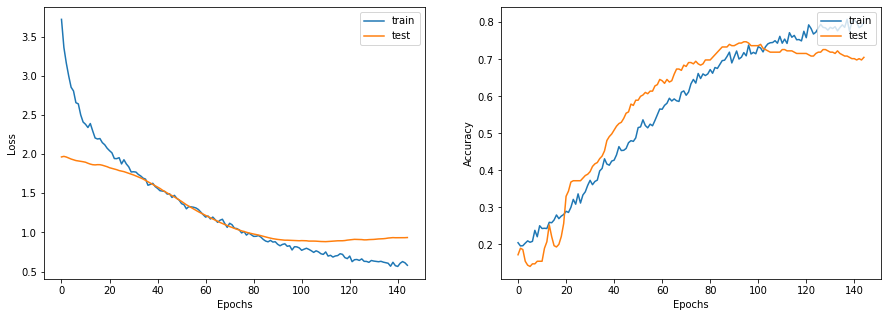

In [ ]:
display_learning_curves(history_1)

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.18%


In [ ]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [ ]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 371ms/step
Instance 1:
- Case_Based: 3.58%
- Genetic_Algorithms: 2.08%
- Neural_Networks: 69.74%
- Probabilistic_Methods: 6.7%
- Reinforcement_Learning: 1.67%
- Rule_Learning: 2.22%
- Theory: 14.02%
Instance 2:
- Case_Based: 0.27%
- Genetic_Algorithms: 0.38%
- Neural_Networks: 98.27%
- Probabilistic_Methods: 0.32%
- Reinforcement_Learning: 0.44%
- Rule_Learning: 0.04%
- Theory: 0.28%
Instance 3:
- Case_Based: 3.41%
- Genetic_Algorithms: 52.91%
- Neural_Networks: 27.38%
- Probabilistic_Methods: 3.43%
- Reinforcement_Learning: 2.44%
- Rule_Learning: 3.4%
- Theory: 7.02%
Instance 4:
- Case_Based: 5.0%
- Genetic_Algorithms: 4.03%
- Neural_Networks: 30.66%
- Probabilistic_Methods: 5.16%
- Reinforcement_Learning: 2.32%
- Rule_Learning: 10.15%
- Theory: 42.68%
Instance 5:
- Case_Based: 5.66%
- Genetic_Algorithms: 50.31%
- Neural_Networks: 3.94%
- Probabilistic_Methods: 3.18%
- Reinforcement_Learning: 2.27%
- Rule_Learning: 17.95%
- Theory: 16.7%
Insta

In [ ]:
edges = citations[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
       
        if self.combination_type == "gru":
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):

        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        return self.update(node_repesentations, aggregated_messages)

In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.04244496  0.07408668  0.23159036  0.07385917  0.12708363  0.0835216
  -0.037712  ]
 [-0.00826977 -0.03403173  0.18189542  0.06847268 -0.01513625  0.04823739
   0.03768122]
 [-0.01322098  0.1013305   0.04534799 -0.01717513  0.02612933 -0.06806313
   0.0413879 ]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                             

In [ ]:
x_train = train_data.paper_id.to_numpy()
history_2 = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
7/7 [==============================] - 7s 352ms/step - loss: 2.3237 - acc: 0.1691 - val_loss: 1.9331 - val_acc: 0.2211
Epoch 2/300
7/7 [==============================] - 1s 166ms/step - loss: 2.3016 - acc: 0.1629 - val_loss: 1.9291 - val_acc: 0.1579
Epoch 3/300
7/7 [==============================] - 1s 165ms/step - loss: 2.1983 - acc: 0.1846 - val_loss: 1.9216 - val_acc: 0.1474
Epoch 4/300
7/7 [==============================] - 1s 164ms/step - loss: 2.1137 - acc: 0.2020 - val_loss: 1.9135 - val_acc: 0.1439
Epoch 5/300
7/7 [==============================] - 1s 165ms/step - loss: 2.1421 - acc: 0.2007 - val_loss: 1.9054 - val_acc: 0.1474
Epoch 6/300
7/7 [==============================] - 1s 165ms/step - loss: 2.0428 - acc: 0.2094 - val_loss: 1.8972 - val_acc: 0.1754
Epoch 7/300
7/7 [==============================] - 1s 165ms/step - loss: 2.0044 - acc: 0.2423 - val_loss: 1.8899 - val_acc: 0.2456
Epoch 8/300
7/7 [==============================] - 1s 165ms/step - loss: 2.0269 - a

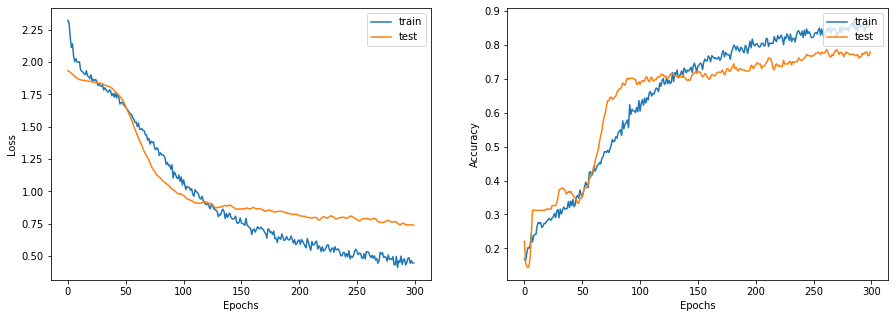

In [ ]:
display_learning_curves(history_2)

In [ ]:
x_test = test_data.paper_id.to_numpy()
_, test_accuaracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 73.18%
